In [122]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt

# Homework 14 - Attention Mechanism

Your task is to implement a custom attention layer. Even though your implementation should be very general, we will load the parameters of the first attention layer of the GPT-2 model and make sure that your implementation mirrors the first attention layer of the GPT-2 model.

In [123]:
def create_causal_mask(seq_len):
    """
    Create a causal mask for the sequence.

    It should an upper triangular matrix with the shape (seq_len, seq_len)
    with ones on the diagonal and below. Above the diagonal should be zeros.

    :param seq_len: Length of the sequence
    :returns: A boolean causal mask tensor of shape (seq_len, seq_len)
    """
    # <your_code_here>
    mask = None
    # </your_code_here>
    return mask


def custom_attention_block(x, W_qkv, b_qkv, W_o, b_o, num_heads=12):
    """
    Custom GPT-2 attention block that mirrors the model's first attention layer.

    Plan of action:
    1. Compute Q, K, V with a single matrix multiplication (QKV = x @ W_qkv + b_qkv)
    2. Split QKV into Q, K, V
    3. Create a causal mask
    4. Compute scaled dot-product attention scores (scores = Q @ K.T / sqrt(head_dim))
    5. Apply causal mask to scores
    6. Compute attention weights (softmax(scores))
    7. Apply attention weights to V
    8. Transpose and reshape back to (seq_len, d_k)
        Note: d_k is the dimension of the embedding for a single head.
        d_k * num_heads = hidden_dim (the dimension of the embedding for the whole sequence)
    9. Apply output projection (out = out @ W_o + b_o)

    The main challenge comes from three things:
    - We need to introduce parallelized heads - please look up how to do it (ChatGPT :))
    - We need to be careful with the dimensions of the matrices when multiplying them.
        Using torch.einsum is a good idea.
        It allows us to write the code in a way that is easy to understand and debug.
    - We need to apply the causal mask to the scores

    :param x: Input activations of shape (seq_len, hidden_dim).
        Note: hidden_dim is what we called embedding dimension in the lecture.
    :param W_qkv: Combined QKV projection weights
    :param b_qkv: Combined QKV projection biases
        Note: In the lecture I mentioned separate W_q, W_k and W_v. In this implementation
        we use a single matrix W_qkv for all three (parallelized). Same for biases.
    :param W_o: Output projection weights
    :param b_o: Output projection biases
    :param num_heads: Number of attention heads (default 12, as in GPT-2). Attention heads
        parallelize the computation of the attention.
    :returns: 1) Output after applying attention, shape (seq_len, hidden_dim)
              2) Attention weights, shape (num_heads, seq_len, seq_len)
    """
    # <your_code_here>
    out, attn_weights, causal_mask = None, None, None
    # </your_code_here>
    return out, attn_weights, causal_mask

In [124]:
def plot_attention_block_outputs(text, tokenizer, attn_weights, causal_mask):
    """
    Plot attention weights and causal mask for a given text input.

    :param text: Input text string
    :param tokenizer: Tokenizer object to convert text to tokens
    :param attn_weights: Attention weights tensor of shape (num_heads, seq_len, seq_len)
    :param causal_mask: Causal mask tensor of shape (seq_len, seq_len)
    """
    # convert text to tokens
    tokens = tokenizer(text, return_tensors="pt")
    # convert tokens back to text representation
    tokens_str = tokenizer.convert_ids_to_tokens(tokens.input_ids[0])

    # Create figure with subplots for attention heads
    num_heads = attn_weights.shape[0]
    fig1, axes1 = plt.subplots(6, 2, figsize=(16, 24))
    axes1 = axes1.flatten()

    # Plot attention weights heatmap for each head
    for head_idx in range(num_heads):
        im = axes1[head_idx].imshow(
            attn_weights.detach().numpy()[head_idx], cmap="viridis", aspect="auto"
        )
        axes1[head_idx].set_title(f"Attention weights for head {head_idx}")

        # Add token labels for both x and y axes for all plots
        axes1[head_idx].set_xticks(range(len(tokens_str)))
        axes1[head_idx].set_xticklabels(tokens_str, rotation=45, ha="right")
        axes1[head_idx].set_yticks(range(len(tokens_str)))
        axes1[head_idx].set_yticklabels(tokens_str)
        
        # Add colorbar for each subplot
        cbar = fig1.colorbar(im, ax=axes1[head_idx])
        cbar.ax.set_ylabel("Attention Weight Values", rotation=-90, va="bottom")

    # Add overall labels for attention weights
    fig1.text(0.5, 0.02, "Key Tokens", ha="center")
    fig1.text(0.02, 0.5, "Query Tokens", va="center", rotation=90)

    plt.tight_layout()
    plt.show()

    # Create separate figure for causal mask
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    im = ax2.imshow(causal_mask.detach().numpy(), cmap="gray", aspect="auto")
    ax2.set_title("Causal Mask")
    ax2.set_xticks(range(len(tokens_str)))
    ax2.set_xticklabels(tokens_str, rotation=45, ha="right")
    ax2.set_yticks(range(len(tokens_str)))
    ax2.set_yticklabels(tokens_str)
    cbar = ax2.figure.colorbar(im, ax=ax2)
    cbar.ax.set_ylabel("Causal Mask Values", rotation=-90, va="bottom")

    # Add labels for causal mask
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.tight_layout()
    plt.show()

In [125]:
"""
Demonstrates how to:
1. Fetch the Hugging Face GPT-2 model.
2. Fetch the first activation matrix (N×d).
3. Extract trainable parameters of the first attention layer.
4. Implement a custom attention layer.
5. Run the custom layer and assert outputs match the original layer.
"""

# 1. Fetch the Hugging Face model and tokenizer
model_name = "gpt2"  # Using the smallest GPT-2 model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure we're in eval mode and on CPU (or GPU if you prefer)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Some dummy text to get an activation batch
text = "A cat is chasing a mouse and it is very funny."
inputs = tokenizer(text, return_tensors="pt").to(device)

# 2. Get the first activation matrix from the model
first_activations = {}


def store_activations(module, input, output):
    first_activations["output"] = output.detach()


# Register hook on the embedding layer
embedding_module = model.transformer.wte
hook = embedding_module.register_forward_hook(store_activations)

# Run a forward pass to collect the embedding output
with torch.no_grad():
    _ = model(**inputs)
hook.remove()

# Get the activation matrix (batch_size, seq_length, hidden_dim)
activation_matrix = first_activations["output"]
activation_matrix = activation_matrix.squeeze(0)  # Remove batch dimension

# 3. Extract the trainable parameters of the first attention layer
first_attention_layer = model.transformer.h[0].attn

# In GPT-2, Q,K,V are computed from a single matrix multiplication
hidden_dim = activation_matrix.size(-1)
W_qkv = first_attention_layer.c_attn.weight  # shape: (hidden_dim, 3*hidden_dim)
b_qkv = first_attention_layer.c_attn.bias  # shape: (3*hidden_dim,)

# Output projection
W_o = first_attention_layer.c_proj.weight
b_o = first_attention_layer.c_proj.bias

print("Shape of W_qkv:", W_qkv.shape)
print("Shape of b_qkv:", b_qkv.shape)
print("Shape of W_o:", W_o.shape)
print("Shape of b_o:", b_o.shape)


Shape of W_qkv: torch.Size([768, 2304])
Shape of b_qkv: torch.Size([2304])
Shape of W_o: torch.Size([768, 768])
Shape of b_o: torch.Size([768])


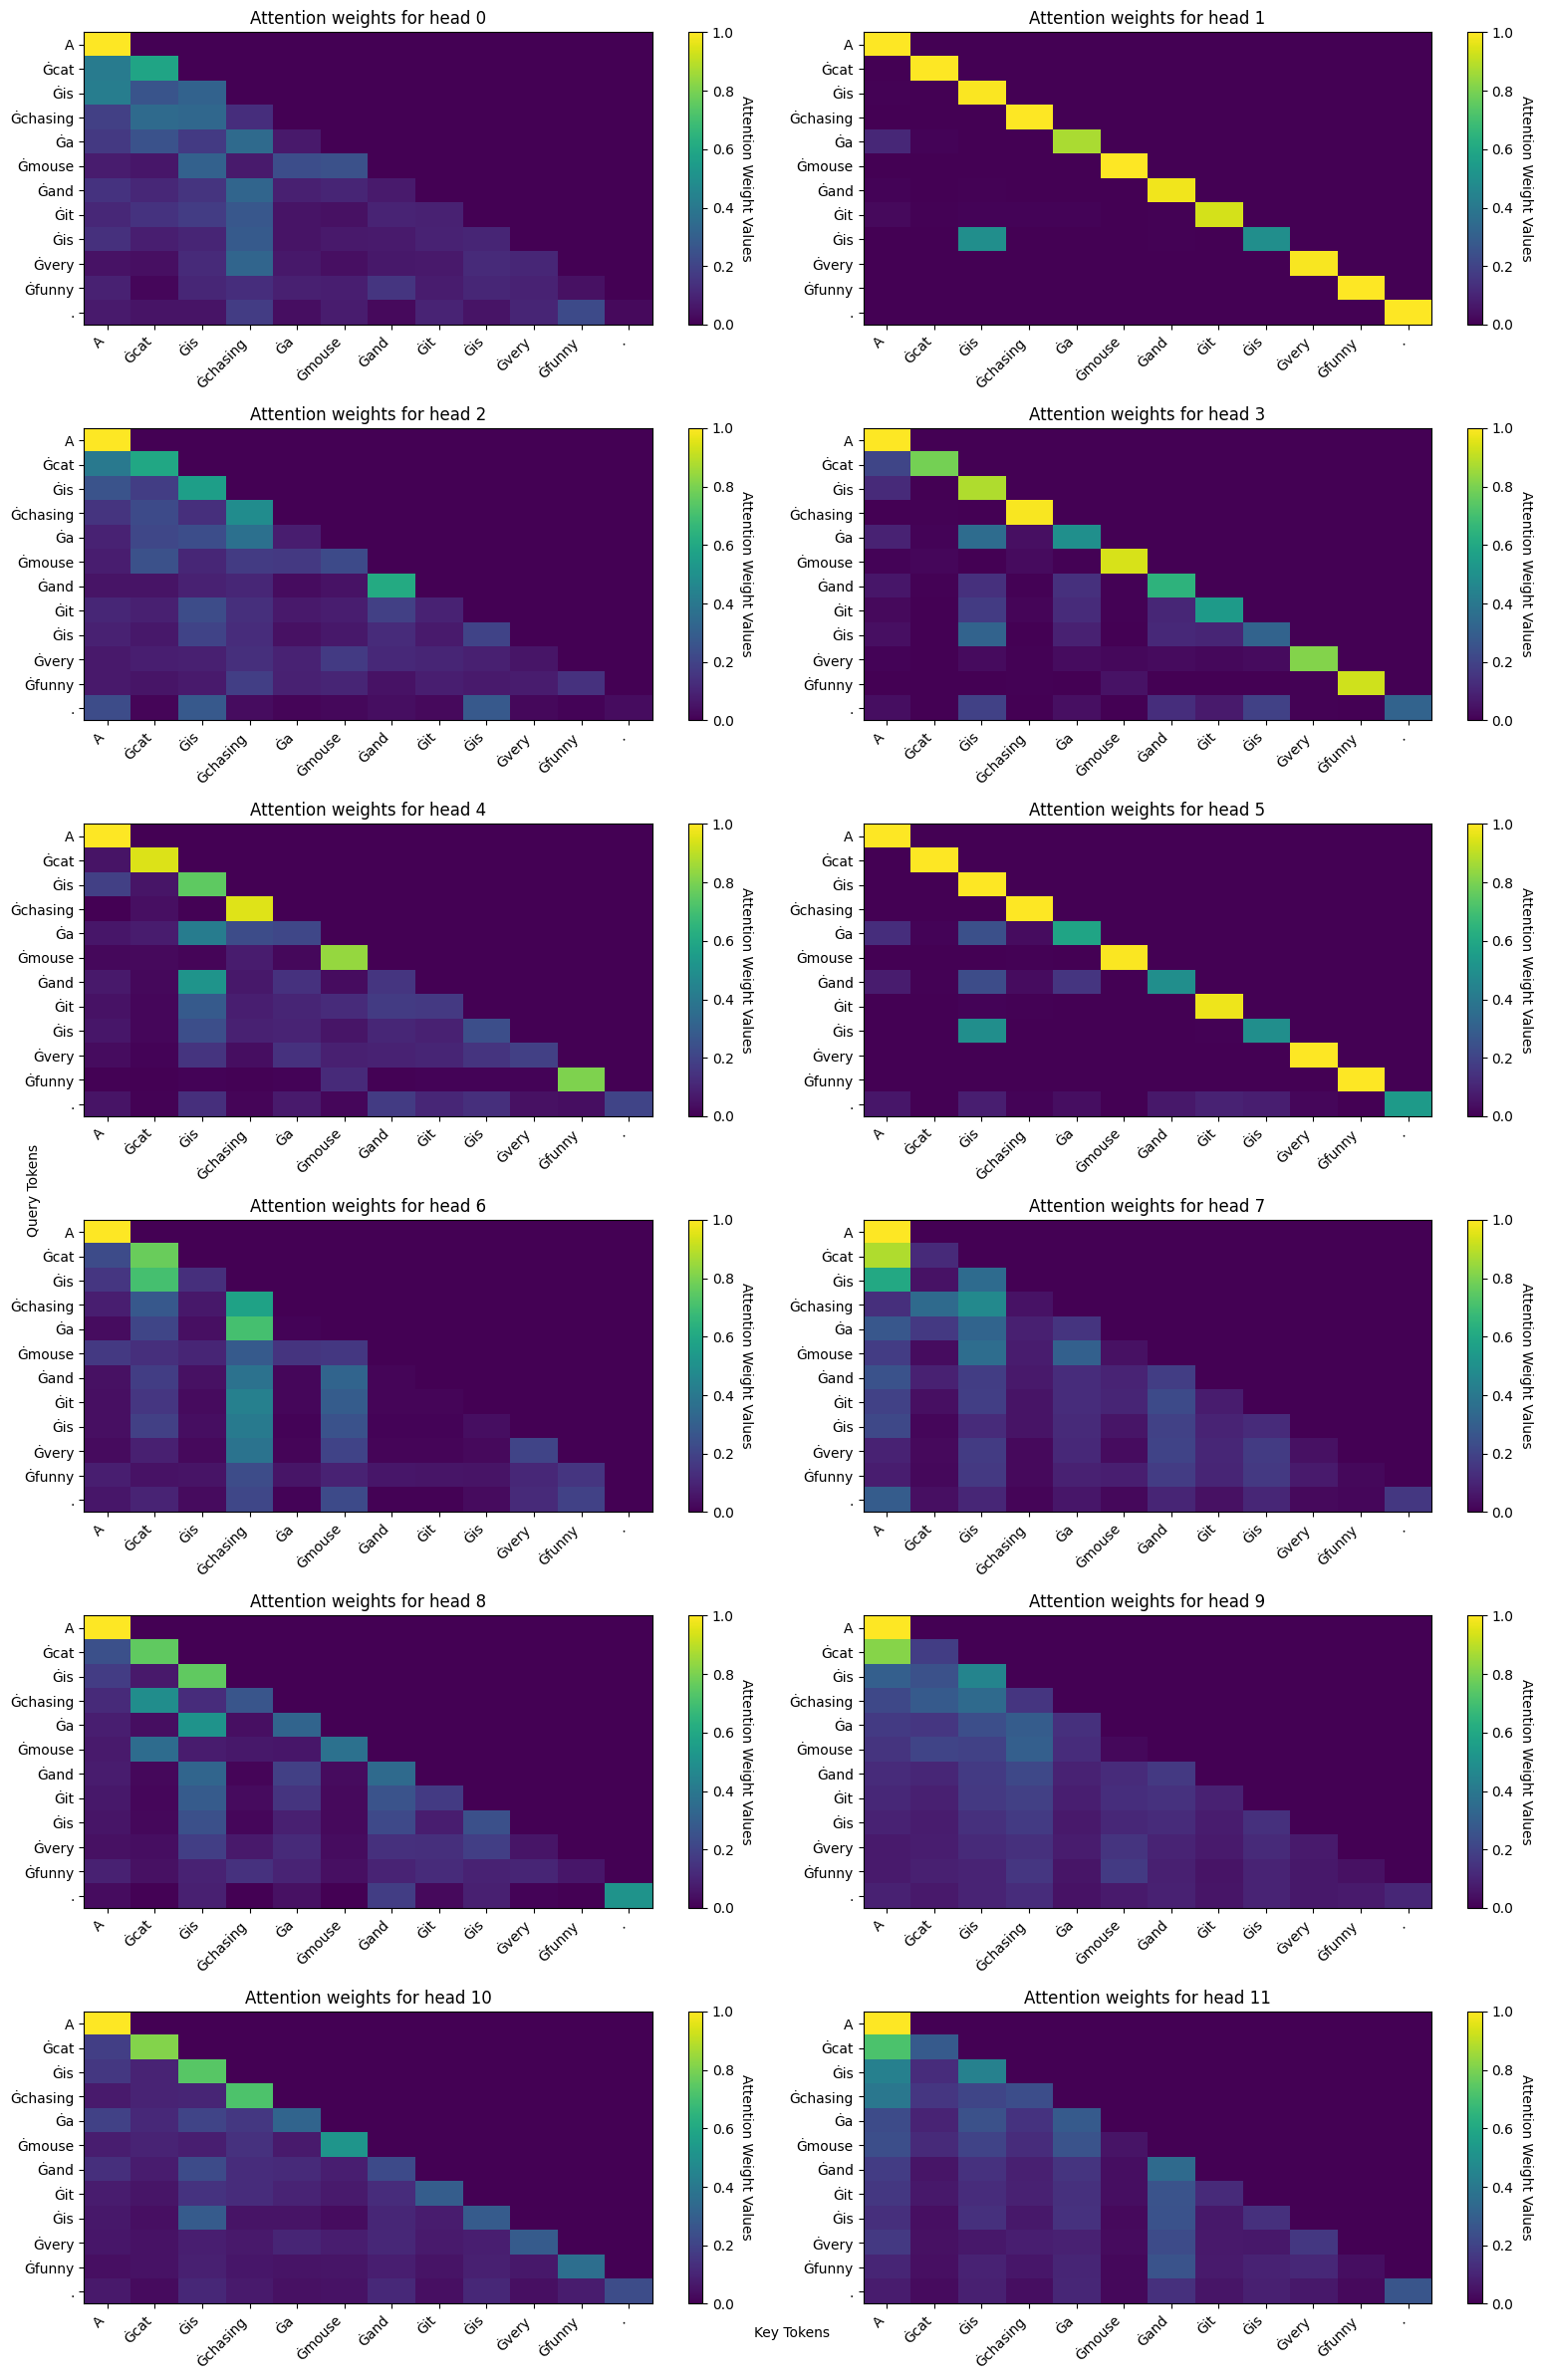

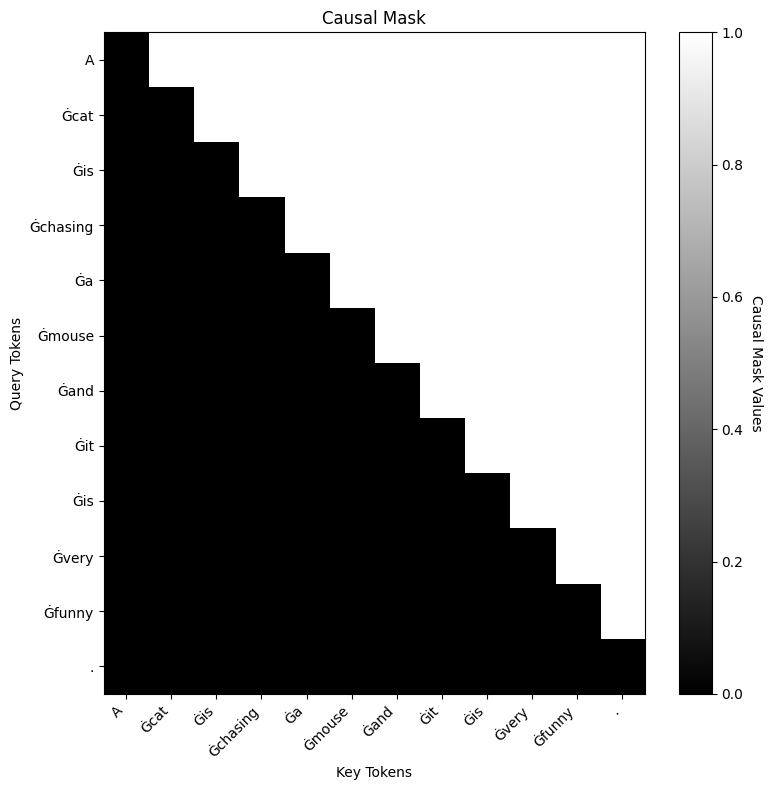

Success: Custom attention output matches the original.


In [126]:
# 5. Run the custom attention layer and compare with the original layer's result
with torch.no_grad():
    # Model's original forward for the first block
    block_input = activation_matrix.unsqueeze(0)  # shape (1, seq_len, hidden_dim)

    # Create attention mask for GPT-2 (causal mask)
    attention_mask = torch.ones(1, block_input.size(1)).to(device)

    original_attn_out = first_attention_layer(
        hidden_states=block_input,
        layer_past=None,
        attention_mask=attention_mask,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=False,
        output_attentions=True,
    )

    original_attn_output = original_attn_out[0].squeeze(0)

    # Now check our custom attention
    custom_attn_out, attn_weights, causal_mask = custom_attention_block(
        activation_matrix, W_qkv, b_qkv, W_o, b_o
    )

    plot_attention_block_outputs(text, tokenizer, attn_weights, causal_mask)

    # Validate that the two outputs are close
    if torch.allclose(original_attn_output, custom_attn_out, atol=1e-5):
        print("Success: Custom attention output matches the original.")
    else:
        # Inspect differences
        diff = (original_attn_output - custom_attn_out).abs().max()
        print(f"Warning: Outputs differ. Max difference: {diff.item()}")
        # Raise an assertion
        assert False, (
            f"Custom attention output does not match the original. Max diff: {diff.item()}"
        )
